# XGboost regression for solubility prediction

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error

In [4]:
# load dataset we are using
df = pd.read_csv('curated_aqsoldb.csv')

In [5]:
# creating x matrix from descriptors chosen
x = df[['MolLogP', 'MolWt', 'NumRotatableBonds', 'AP']]
x

,MolLogP,MolWt,NumRotatableBonds,AP
0,3.95810,392.510,17.0,0.000000
1,2.40550,169.183,0.0,0.769231
2,2.15250,140.569,1.0,0.666667
3,8.11610,756.226,10.0,0.679245
4,2.48540,422.525,12.0,0.387097
...,...,...,...,...
10058,2.61700,264.369,8.0,0.315789
10059,-0.21440,444.440,2.0,0.187500
10060,2.82402,150.221,1.0,0.545455
10061,5.09308,454.611,13.0,0.363636


In [6]:
# creating y matrix from Solubility values
y = df['Solubility']

In [7]:
# split dataset into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y)

Dmatrix is an optimized data structure that XGboost uses. Here we will input our descriptors as the data parameter and solubility values as the label parameter.

In [6]:
# create D matrix where data is the descriptors being used and label is the solubility values
dtrain = xgb.DMatrix(data=x_train,label=y_train)

In [7]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.8, learning_rate = 0.1, max_depth = 7, n_estimators = 1000)

In [8]:
xg_reg.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [9]:
y_predict = xg_reg.predict(x_test)

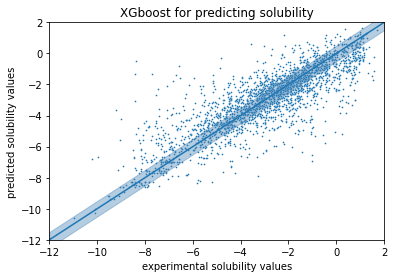

In [10]:
sns.scatterplot(x=y_test, y=y_predict, s=3).set(title='XGboost for predicting solubility', xlabel='experimental solubility values', ylabel='predicted solubility values')

plt.xlim(-12, 2)
plt.ylim(-12, 2)

# plot x=y line showing where accurate predictions lie
sns.lineplot(x=[-12, 2], y=[-12, 2], alpha=1)

# shaded areas show values that lie within the accepted +- 0.5 error zone
exp_value = np.arange(-12, 3)
upper_bound = exp_value + 0.5
lower_bound = exp_value - 0.5
plt.fill_between(exp_value, upper_bound, lower_bound, color='steelblue', alpha=0.4)

In [11]:
# check how many values fall within the allowed error boundary (of 0.5)
good_value_count = 0
for pred, exp in zip(y_predict, y_test):
    if exp - 0.5 <= pred <= exp + 0.5:
        good_value_count += 1

In [12]:
good_value_count

1111

In [14]:
len(y_test)

2516

In [16]:
print ('So', good_value_count / len(y_test) * 100,'% of the test set are predicted within 0.5 of the experimental values.')

So 44.15739268680446 % of the test set are predicted within 0.5 of the experimental values.


### Hypertuning Parameters

In [25]:
param_grid = { 'max_depth': [3,6,10],
               'learning_rate': [0.01, 0.05, 0.1],
               'n_estimators': [100, 500, 1000],
               'colsample_bytree': [0.3, 0.7]}

In [26]:
xgbr = xgb.XGBRegressor()

In [27]:
cvFold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
xgbr_grid = GridSearchCV(estimator=xgbr, param_grid=param_grid, n_jobs=-1, cv=cvFold, scoring="r2")
results = xgbr_grid.fit(x_train, y_train)

In [28]:
xgbr_grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 6,
 'n_estimators': 1000}

In [29]:
best_model = results.best_estimator_

In [30]:
best_model.score(x_test, y_test)

0.6915917295531415

In [31]:
best_model.score(x_train, y_train)

0.7998039449897413

In [32]:
y_tuned_predict = best_model.predict(x_test)

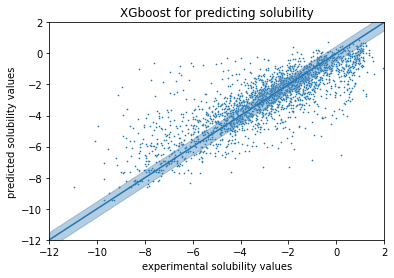

In [33]:
sns.scatterplot(x=y_test, y=y_tuned_predict, s=3).set(title='XGboost for predicting solubility', xlabel='experimental solubility values', ylabel='predicted solubility values')

plt.xlim(-12, 2)
plt.ylim(-12, 2)

# plot x=y line showing where accurate predictions lie
sns.lineplot(x=[-12, 2], y=[-12, 2], alpha=1)

# shaded areas show values that lie within the accepted +- 0.5 error zone
exp_value = np.arange(-12, 3)
upper_bound = exp_value + 0.5
lower_bound = exp_value - 0.5
plt.fill_between(exp_value, upper_bound, lower_bound, color='steelblue', alpha=0.4)

In [34]:
# check how many values fall within the allowed error boundary (of 0.5)
good_value_count = 0
for pred, exp in zip(y_tuned_predict, y_test):
    if exp - 0.5 <= pred <= exp + 0.5:
        good_value_count += 1

In [35]:
good_value_count

1002

In [36]:
len(y_test)

2516

In [37]:
print ('So', good_value_count / len(y_test) * 100,'% of the test set are predicted within 0.5 of the experimental values.')

So 39.82511923688394 % of the test set are predicted within 0.5 of the experimental values.
